# Prognostics for Turbofine Engines with 1D Convolutional Neural Networks 🩺

Prognostics is the prediction of Remaining useful life of instance of failure of a component based on the knowledge about current and future coditions of operation (obtained through various sensors or physical models).

The new C-MAPSS dataset DS02 from NASA provides degradation trajectories of 9 turbofan engines with unknown and different initial health condition for complete flights and two failure modes (HPT efficiency degradation & HPT efficiency degradation combined with LPT efficiency and capacity degradation). The data were synthetically generated with the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS) dynamical model. The data contains multivariate sensors readings of the complete run-to-failure trajectories. Therefore, the records stop at the cycle/time the engine failed. A total number of 6.5M time stamps are available. Dataset copyright (c) by Manuel Arias.

**For training simplicity, the dataset has been preprocessed. The dataset has been downsampled from 1Hz to 0.1 Hz with an IIR 8th Order Chebyshev filter. Data format has been converted from double to float precison.**

## Imports 💼

In [1]:
import os
import time 
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [82]:
import warnings
warnings.filterwarnings("ignore")

## Download dataset 🔗

Download the dataset from [Google Drive Link](https://drive.google.com/file/d/1jXC3BQmEkupXkJbuXM52-Lf6ADLzR4Rr/view?usp=sharing) and put it in the folder of this notebook.

In [2]:
folder = os.getcwd()
filename = f'{folder}/ncmapps_ds02.csv'
print(filename)

/Users/sopheabonnne/EPFL/CIVIL-426/ml4pm/assignment_3/ncmapps_ds02.csv


# Data exploration 🔍

<img src="images/cmapss.png" width="700"/>

### Feature descriptions

| Symbol |           Description           | Units |
|:------:|:-------------------------------:|:-----:|
|   Wf   |            Fuel flow            |  pps  |
|   Nf   |        Physical fan speed       |  rpm  |
|   Nc   |       Physical core speed       |  rpm  |
|   T24  | Total temperature at LPC outlet |   °R  |
|   T30  | Total temperature at HPC outlet |   °R  |
|   T48  | Total temperature at HPT outlet |   °R  |
|   T50  | Total temperature at LPT outlet |   °R  |
|   P15  |  Total pressure in bypass-duct  |  psia |
|   P2   |   Total pressure at fan inlet   |  psia |
|   P21  |   Total pressure at fan outlet  |  psia |
|   P24  |   Total pressure at LPC outlet  |  psia |
|  Ps30  |  Static pressure at HPC outlet  |  psia |
|   P40  | Total pressure at burner outlet |  psia |
|   P50  |   Total pressure at LPT outlet  |  psia |
|   alt  |             Altitude            |   ft  |
|  Mach  |        Flight Mach number       |   -   |
|   TRA  |     Throttle–resolver angle     |   %   |
|   T2   |  Total temperature at fan inlet |   °R  |
|  cycle |       Flight cycle number       |   -   |
|   Fc   |           Flight class          |   -   |
|   hs   |           Health state          |   -   |

In [3]:
df = pd.read_csv(filename)
df.head()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1


In [4]:
df.describe()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
count,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,...,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000,651719.000000
mean,553.773261,1305.850995,1624.971227,1095.696343,10.873508,8.294637,11.039095,13.643750,208.496462,212.067515,...,2.253705,21119.237345,0.610494,67.194135,470.945280,36.166254,2.885379,11.667088,0.242413,36.923423
std,17.911969,55.450514,98.490373,51.542820,2.151641,1.772237,2.184407,2.623686,44.015363,44.661923,...,0.570109,6289.970530,0.079231,14.527711,16.562547,21.888520,0.386773,6.039347,0.428543,21.871899
min,478.632600,1059.667800,1209.931600,880.090700,5.852047,4.347817,5.941164,6.836902,79.552380,81.277596,...,0.669135,9882.690000,0.307302,19.149189,417.287570,0.000000,1.000000,2.000000,0.000000,1.000000
25%,541.163970,1275.104050,1576.463600,1062.239200,9.047318,6.723060,9.185095,11.490683,177.011890,180.088135,...,1.862427,15698.589500,0.552379,57.695049,457.398350,18.000000,3.000000,5.000000,0.000000,18.000000
50%,551.275940,1304.876100,1634.922400,1087.750400,10.440776,7.942872,10.599772,13.147205,198.354350,201.783000,...,2.120128,21750.955000,0.623288,73.139915,469.305800,35.000000,3.000000,11.000000,0.000000,36.000000
75%,565.815665,1340.213050,1683.188100,1128.510400,12.557189,9.760832,12.748416,15.541450,235.666880,239.740805,...,2.575994,26692.051500,0.673824,78.666230,485.250000,54.000000,3.000000,18.000000,0.000000,54.000000
max,610.117900,1484.438500,1920.566000,1282.403800,16.686320,12.159272,16.940426,21.708801,376.933350,382.565220,...,4.619399,34629.797000,0.738229,91.356170,505.425720,88.000000,3.000000,20.000000,1.000000,89.000000


### Flight Classes

The units are divided into three flight classes depending on whether the unit is operating short-length flights (i.e., flight class 1), medium-length flights (i.e., flight class 2), or long-length flights (i.e., flight class 2). A number of real flight conditions are available within each of the flight classes.

| Flight Class   | Flight Length [h]
| :-----------:  | :-----------:    
| 1              |    1 to 3        
| 2              |    3 to 5        
| 3              |    5 to 7        

<Axes: xlabel='Unit # [-]', ylabel='Flight Class # [-]'>

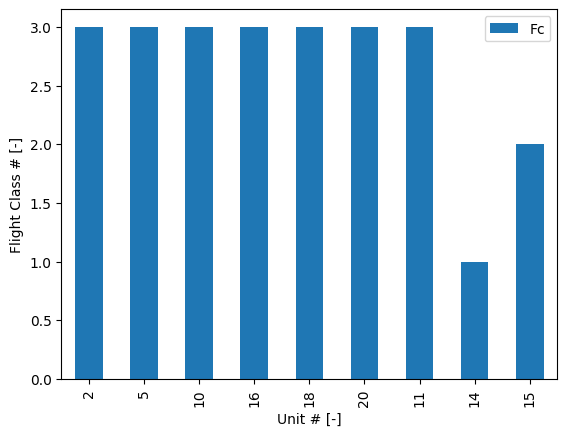

In [5]:
df.drop_duplicates(
    subset=['unit','Fc'], keep='last'
    ).plot(
        x='unit', y='Fc', 
        kind='bar', 
        xlabel='Unit # [-]', 
        ylabel='Flight Class # [-]'
    )

## Feature Overview

In [6]:
LABELS = ['RUL']

Operative Conditions ($w$)

DASHlink- Flight Data For Tail 687.(2012). Retrieved on 2019-01-29 from https://c3.nasa.gov/dashlink/

In [7]:
W_VAR = ['alt', 'Mach', 'TRA', 'T2']

Sensor readings ($X_s$)

In [8]:
XS_VAR = ['T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50', 'Nf', 'Nc', 'Wf']


<Axes: >

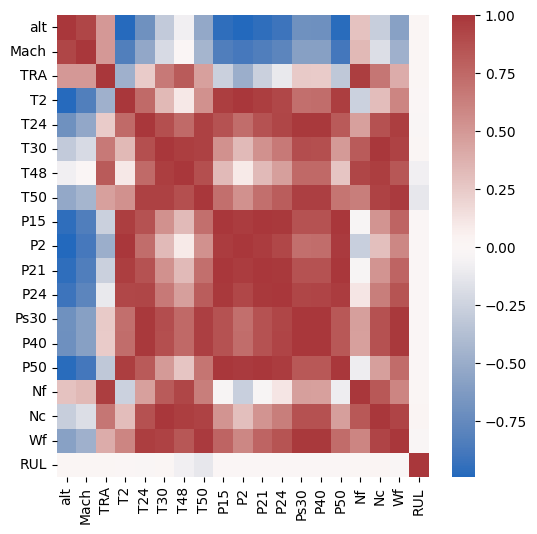

In [125]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.heatmap(df[W_VAR+XS_VAR+LABELS].corr(), cmap="vlag")

### Flight Traces
visualize a single flight trace of a given unit

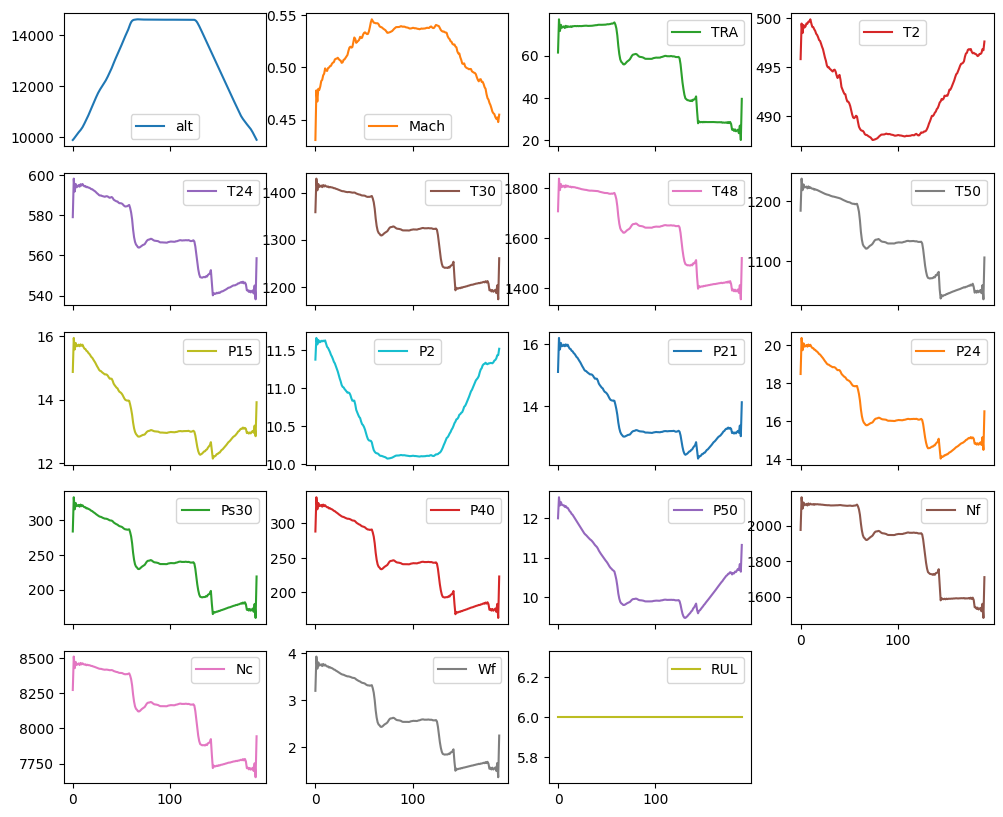

In [56]:
unit = 14
cycle = 70
df_u_sel = df.loc[(df.unit == unit) & (df.cycle == cycle)][W_VAR+XS_VAR + LABELS]
df_u_sel.reset_index(inplace=True, drop=True)
axes = df_u_sel.plot(figsize=(12, 10), subplots=True, layout=(5, 4))

### Flight envelope

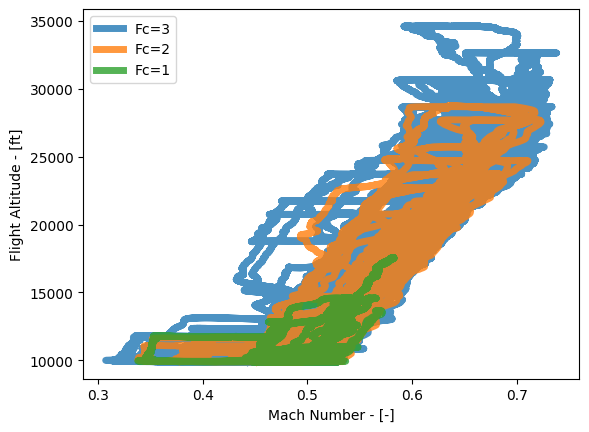

In [11]:
f, ax = plt.subplots(1, 1)
for i in [3, 2, 1]:
    df.loc[df['Fc'] == i].plot(x='Mach', y='alt', alpha=0.8, label=f'Fc={i}', ax=ax, lw=5)
plt.xlabel('Mach Number - [-]')
plt.ylabel('Flight Altitude - [ft]')
plt.legend()

## Histogram of Flight Conditions

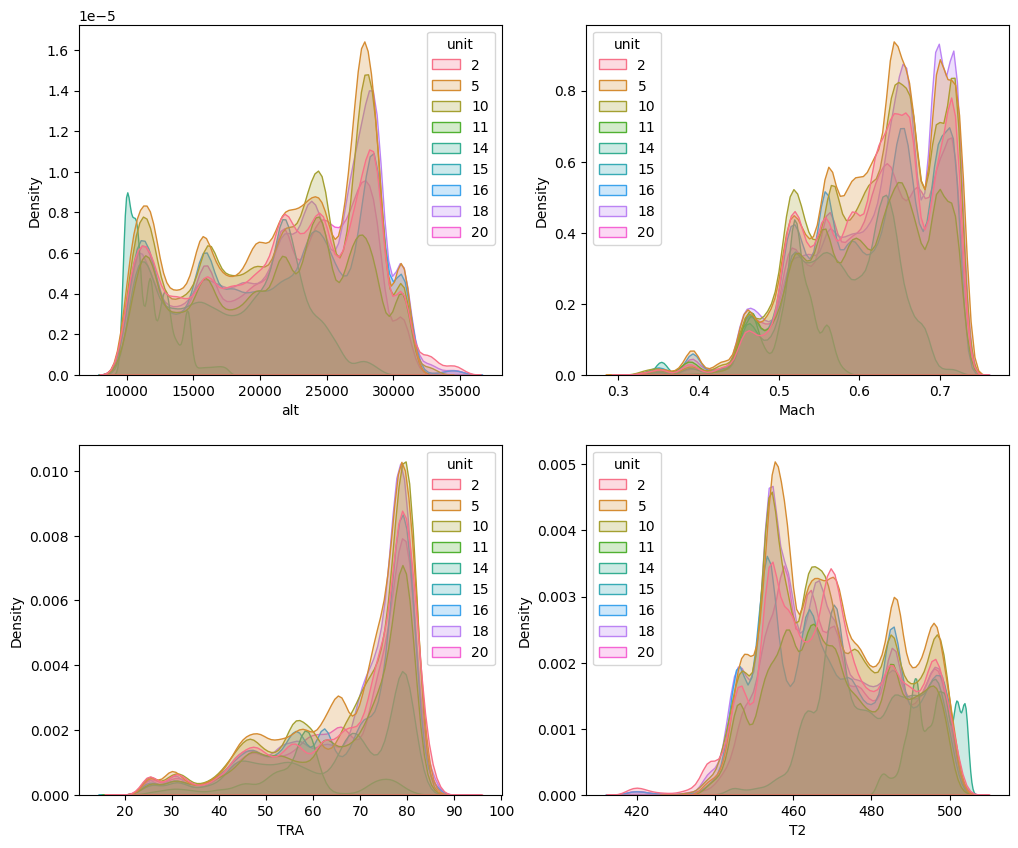

In [83]:
f, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, var in enumerate(W_VAR):
    sns.kdeplot(data=df[W_VAR+['unit']], x=var, hue='unit', shade=True, gridsize=100, ax=axes[i//2][i%2], palette=sns.color_palette("husl", 9))

# Sophea's EDA

### Degredation of RUL for each Unit
The RUL degrades at a constant rate for all the units, but faster for units 14 and 15. Unit 14 has the steepest slope, and this can be explained because it's used for Flight class 1 which is the shortest distance flights. This means that it's making more take-offs and landings compared to the time spent in cruising. Take off is the most strenous part of each flight on the engine, so unit 14 degrades the fastest.

We also notice that the starting point of RUL isn't consistent across all the units. For instance, Unit 5 starts at 88 and unit 11 starts at 58. This makes the model struggle to generalize. 

Since we only train the model on units in flight class 3, it performs better on test Unit 11.

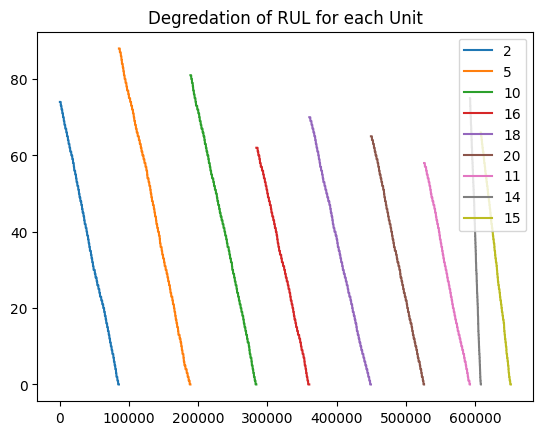

In [160]:
units = [2, 5, 10, 16, 18, 20, 11, 14, 15]
plt.title('Degredation of RUL for each Unit')
for i in units:
    plt.plot(df[df['unit'] == i]['RUL'], label = i)
plt.legend()

In [162]:
df.loc[(df.unit == 11)]['RUL'].max()
# plt.scatter(x = 'T50', y = 'RUL', data = df[df.cycle == cycle])

np.int64(58)

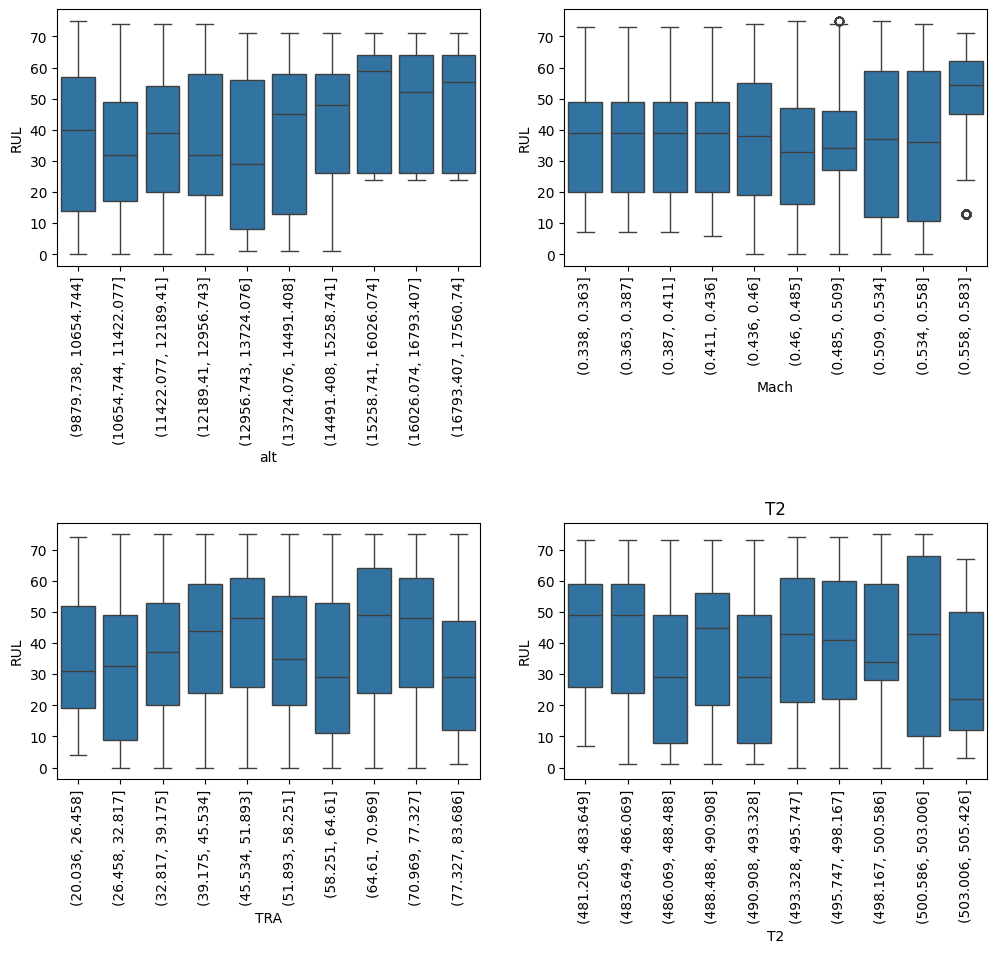

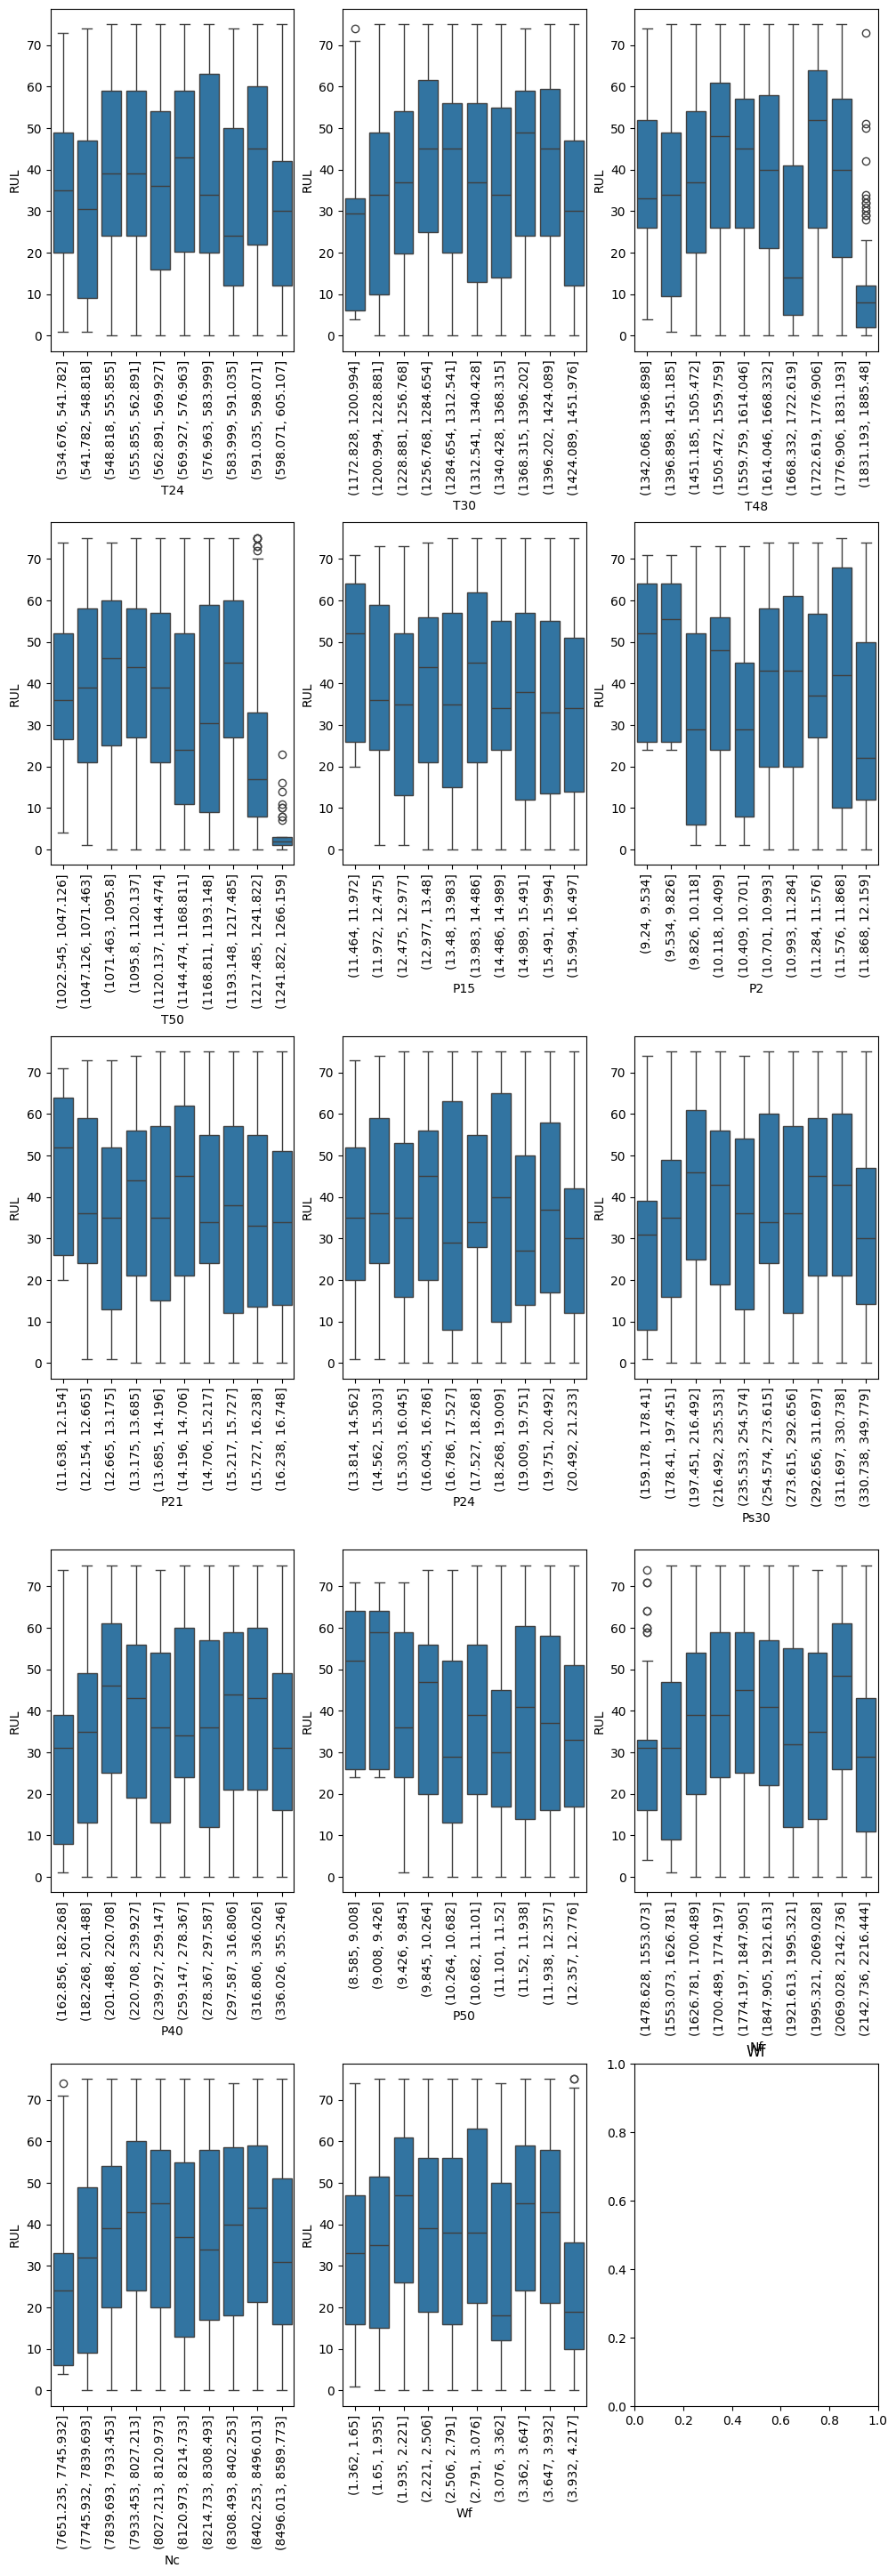

In [85]:
processData = df[df['unit']== 14][W_VAR + LABELS]

f, axes = plt.subplots(2, 2, figsize=(12, 10))
for i, var in enumerate(W_VAR):
    #make 10 groups of range of var to compute boxplot of RUL
    processData[var] = pd.cut(processData[var], 10)
    sns.boxplot(data=processData, x=var, y='RUL', ax=axes[i//2][i%2])
    plt.title(var)
    axes[i//2][i%2].set_xticklabels(axes[i//2][i%2].get_xticklabels(), rotation=90)
    plt.subplots_adjust(hspace=1)  # Increase or decrease the space here



#Same thing but with X_VAR
processData = df[df['unit']== 14][XS_VAR + LABELS]

f, axes = plt.subplots(5, 3, figsize=(12, 35))
for i, var in enumerate(XS_VAR):
    #make 10 groups of range of var to compute boxplot of RUL
    processData[var] = pd.cut(processData[var], 10)
    sns.boxplot(data=processData, x=var, y='RUL', ax=axes[i//3][i%3])
    plt.title(var)
    #show at 1 decimal
    axes[i//3][i%3].set_xticklabels(axes[i//3][i%3].get_xticklabels(), rotation=90)
    plt.subplots_adjust(hspace=0.5)  # Increase or decrease the space here


# Developing your first prognostics model 💻
Step by step, you will learn how to build your first prognostics model from scratch!

## Define Sequence Dataset 


In [66]:
class SlidingWindowDataset(Dataset):
    def __init__(self, dataframe, window=50, stride=1, horizon=1, device='cpu'):
        """Sliding window dataset with RUL label

        Args:
            dataframe (pd.DataFrame): dataframe containing scenario descriptors and sensor reading
            window (int, optional): sequence window length. Defaults to 50.
            stride (int, optional): data stride length. Defaults to 1.
            horizon (int, optional): prediction forcasting length. Defaults to 1.
        """
        self.window = window
        self.stride = stride
        self.horizon = horizon
        
        self.X = np.array(dataframe[XS_VAR+W_VAR].values).astype(np.float32)
        self.y = np.array(dataframe['RUL'].values).astype(np.float32)
        if 'ds' in dataframe.columns:
            unqiue_cycles = dataframe[['ds', 'unit', 'cycle']].value_counts(sort=False)
        else:
            unqiue_cycles = dataframe[['unit', 'cycle']].value_counts(sort=False)
        self.indices = torch.from_numpy(self._get_indices(unqiue_cycles)).to(device)

    # TODO add comment
    # get corresponding indices of the dataframe for sliding windows at pos i
    def _get_indices(self, unqiue_cycles):
        cycles = unqiue_cycles.to_numpy()
        idx_list = []
        for i, c_count in enumerate(cycles):
            c_start = sum(cycles[:i])
            c_end = c_start + (c_count - self.window - self.horizon)
            if c_end + self.horizon < len(self.X): # handling y not in the last seq case
                idx_list += [_ for _ in np.arange(c_start, c_end + 1, self.stride)]
         
        return np.asarray([(idx, idx+self.window) for idx in idx_list])
    
    # find length of data with sliding window
    def __len__(self):
        return len(self.indices)
    
    # get sliding window
    def __getitem__(self, i):
        i_start, i_stop = self.indices[i]
        x = self.X[i_start:i_stop, :]
        y = self.y[i_start]
        x = x.permute(1, 0)
        return x, y

In [111]:
unqiue_cycles = df[['unit', 'cycle']].value_counts(sort=False)
cycles = unqiue_cycles.to_numpy()
unqiue_cycles

unit  cycle
2     1        1177
      2        1050
      3        1109
      4        1073
      5        1145
               ... 
20    62       1357
      63        875
      64       1435
      65        923
      66        957
Name: count, Length: 648, dtype: int64

In [106]:
df[(df['unit'] == 2) & (df['cycle'] == 1)]

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
0,593.28656,1422.0460,1797.2323,1214.0819,15.626362,11.445379,15.864327,19.897537,327.51962,332.79700,...,3.811431,9889.289,0.443401,76.022545,496.67758,74,3,2,1,1
1,593.30220,1422.3720,1797.9927,1214.1847,15.607640,11.424822,15.845321,19.881628,327.48330,332.75565,...,3.812693,9951.729,0.444472,76.222015,496.53890,74,3,2,1,1
2,593.14215,1421.8730,1797.1808,1213.5430,15.581609,11.407368,15.818893,19.848164,326.81784,332.08163,...,3.803472,10011.879,0.445830,76.191210,496.43396,74,3,2,1,1
3,592.98883,1421.4746,1796.5925,1213.0120,15.554759,11.387945,15.791634,19.814800,326.22076,331.47592,...,3.795554,10073.271,0.446986,76.196846,496.30667,74,3,2,1,1
4,592.66296,1420.8185,1795.7623,1212.4274,15.512026,11.356153,15.748249,19.760134,325.36660,330.60760,...,3.784542,10136.359,0.446471,76.204480,496.02774,74,3,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172,543.53656,1201.7744,1386.9922,1039.6594,13.059499,11.354950,13.258374,14.979644,177.67330,181.66016,...,1.602984,10228.006,0.452134,26.401077,496.18353,74,3,2,1,1
1173,541.23900,1191.0237,1366.5066,1031.2908,12.966631,11.381721,13.164093,14.771090,170.56004,174.49342,...,1.495654,10147.563,0.450830,23.871353,496.36752,74,3,2,1,1
1174,545.52680,1209.5779,1401.0835,1046.4286,13.204427,11.410786,13.405509,15.207983,183.38678,187.43175,...,1.684906,10071.315,0.450106,27.974500,496.58716,74,3,2,1,1
1175,539.11020,1180.6692,1346.6833,1023.5741,12.903128,11.439160,13.099622,14.590826,163.64973,167.53730,...,1.388296,9993.242,0.449163,21.228700,496.79425,74,3,2,1,1


In [67]:
def create_datasets(df, window_size, train_units, test_units, device='cpu'):
    df_train = df[df['unit'].isin(train_units)]
    train_dataset = SlidingWindowDataset(df_train, window=window_size)

    df_test = df[df['unit'].isin(test_units)]    
    test_dataset = SlidingWindowDataset(df_test, window=window_size)

    # normalizing features
    scaler = MinMaxScaler()
    train_dataset.X = scaler.fit_transform(train_dataset.X)
    test_dataset.X = scaler.transform(test_dataset.X)

    # convert numpy array to tensors
    datasets = [train_dataset, test_dataset]
    for d in datasets:
        d.X = torch.from_numpy(d.X).to(device)
        d.y = torch.from_numpy(d.y).to(device)
    
    return datasets

def create_data_loaders(datasets, batch_size=256, val_split=0.2):
    # fixed seed for data splits for reproducibility
    random.seed(0)
    np.random.seed(0)
    
    d_train, d_test = datasets
    dataset_size = len(d_train)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader = DataLoader(d_train, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(d_train, batch_size=batch_size, sampler=valid_sampler)
    test_loader = DataLoader(d_test, batch_size=batch_size, shuffle=False)      

    d_info = f"train_size: {len(train_indices)}\t"
    d_info += f"validation_size: {len(val_indices)}\t"
    d_info += f"test_size: {len(d_test)}"
    print(d_info)
    return train_loader, val_loader, test_loader

## Define Trainer Class

In [199]:
class Trainer:
    def __init__(
        self,
        model,
        optimizer,
        n_epochs=20,
        criterion=nn.MSELoss(),
        model_name='best_model',
        seed=42,
        device='cpu'
    ):
        self.seed = seed
        self.model = model
        self.optimizer = optimizer
        self.device = device
        self.n_epochs = n_epochs
        self.criterion = criterion
        
        # adding time_stamp to model name to make sure the save models don't overwrite each other, 
        # you can customize your own model name with hyperparameters so that you can reload the model more easily
        time_stamp = time.strftime("%m%d%H%M%S")
        self.model_path = f'models/{model_name}_{time_stamp}.pt'

        self.losses = {split: [] for split in ['train', 'eval', 'test']}
        
    def compute_loss(self, x, y, model=None):
        y = y.view(-1)
        y_pred = self.model(x)
        y_pred = y_pred.view(-1)
        loss = self.criterion(y, y_pred)
        return loss, y_pred, y
    
    def train_epoch(self, loader):
        self.model.train()
        # batch losses
        b_losses = []
        for x, y in loader:
            # Setting the optimizer gradient to Zero
            self.optimizer.zero_grad()
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))
            
            loss, pred, target = self.compute_loss(x, y)
            
            # Backpropagate the training loss
            loss.backward()
            self.optimizer.step()
            b_losses.append(loss.detach().numpy())
        
        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses['train'].append(agg_loss)
        return agg_loss

    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_epoch(self, loader, split='eval'):
        self.model.eval()
        # batch losses
        b_losses = []
        for x, y in loader:
            x.to(torch.device(self.device))
            y.to(torch.device(self.device))
            
            loss, pred, target = self.compute_loss(x, y)
            
            b_losses.append(loss.detach().numpy())
        
        # aggregated losses across batches
        agg_loss = np.sqrt((np.asarray(b_losses) ** 2).mean())
        self.losses[split].append(agg_loss)
        return agg_loss
        
    def fit(self, loaders):
        print(f"Training model for {self.n_epochs} epochs...")
        train_loader, eval_loader, test_loader = loaders
        train_start = time.time()
        
        start_epoch = 0
        best_eval_loss = np.inf
            
        for epoch in range(start_epoch, self.n_epochs):
            epoch_start = time.time()
            
            train_loss = self.train_epoch(train_loader)
            eval_loss = self.eval_epoch(eval_loader, split='eval')
            test_loss = self.eval_epoch(test_loader, split='test')

            if eval_loss < best_eval_loss:
                best_eval_loss = eval_loss
                self.save(self.model, self.model_path)

            s = (
                f"[Epoch {epoch + 1}] "
                f"train_loss = {train_loss:.5f}, "
                f"eval_loss = {eval_loss:.5f}, "
                f"test_loss = {test_loss:.5f}"
            )

            epoch_time = time.time() - epoch_start
            s += f" [{epoch_time:.1f}s]"
            print(s)
    
        train_time = int(time.time() - train_start)
                
        print(f'Task done in {train_time}s')
    
    @ staticmethod
    def evaluate_model_performance(y_pred, y_true):
        """
        ## Task: Define Model Performance on RMSE and NASA score
        The performance of your implemented model should be evaluated using two common metrics applied in N-CMAPSS prognostics analysis:
        RMSE and NASA-score (in 1E5) as introduced in ["Fusing Physics-based and Deep Learning Models for Prognostics"](https://arxiv.org/abs/2003.00732)
        """
        # TODO: add implementation
        # for NASA score: alpha = 1/13 if RUL is underestimated, and 1/10 otherwise
        alpha = np.where(y_pred < y_true, 1/13, 1/10)
        score = np.exp(alpha * np.abs(y_pred - y_true)) - 1
        score = np.sum(score) / 1e5

        rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
        return score, rmse
    
    # decorator, equivalent to with torch.no_grad():
    @torch.no_grad()
    def eval_rul_prediction(self, test_loader):
        print(f"Evaluating test RUL...")
        
        ## MASK OUT EVAL and add explanation
        best_model = self.load(self.model) 
        best_model.eval()
        
        preds = []
        trues = []
        
        for x, y in tqdm(test_loader):
            x = x.to(self.device)
            y = y.to(self.device)

            _, y_pred, y_target = self.compute_loss(x, y)
            preds.append(y_pred.detach().cpu().numpy())
            trues.append(y_target.detach().cpu().numpy())
        
        preds = np.concatenate(preds, axis=0)
        trues = np.concatenate(trues, axis=0)
        
        df = pd.DataFrame({         
            'pred': preds,
            'true': trues,
            'err': np.sqrt((preds - trues)**2)
        })
        
        score, rmse = self.evaluate_model_performance(preds, trues)
        df_out = pd.DataFrame({
            'score': [score],
            'rmse': [rmse],
            'seed': [self.seed],
        })
        return df, df_out

    def save(self, model, model_path=None):
        os.makedirs(f'{folder}/models', exist_ok=True)
        if model_path is None:
            model_path = self.model_path 
        torch.save(model.state_dict(), model_path)
        
    def load(self, model, model_path=None):
        """
        loads the prediction model's parameters
        """
        if model_path is None:
            model_path = self.model_path
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        print(f"Model {model.__class__.__name__} saved in {model_path} loaded to {self.device}")
        return model

    def plot_losses(self):
        """
        :param losses: dict with losses
        """
        linestyles = {
            'train': 'solid', 
            'eval': 'dashed', 
            'test': 'dotted', 
        }
        for split, loss in self.losses.items():
            ls = linestyles[split]
            plt.plot(range(1, 1+len(loss)), loss, label=f'{split} loss', linestyle=ls)
            plt.yscale('log')
                
        plt.title("Training/Validation Losses")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()


# Task: Implement a 1D Convolutional Neural Network (1DCNN) Model
Conventional CNN's developed for image tasks learn to extract features from the 2D input data. They are autonomous (require no domain expertise or prior info about the image) and thus can be applied to any image regardless of its dimensions. This is due to the fact that these CNN's go through an image by downsampling the image which we call straddling or windowing.  

Similarly 1D CNN learns to extract features from a time series data, by windowing over the data, considering a set of data observations each time. The benefit of using the CNN for sequence classification is that it can learn from the raw time series data, and in turn do not require domain expertise to engineer relevant features.

The CNN architecture outlined in the paper consists of five layers. The initial three layers are convolutional layers, each employing filters of size 10. The first two convolutional layers consist of ten channels each, while the third convolutional layer comprises a single channel. Zero padding is utilized to maintain the dimensions of the feature map throughout the network. Following the convolutional layers, the 2D feature map is flattened, leading into a 50-unit fully connected layer, and subsequently, a linear output neuron. The activation function used across the network is ReLU. The network encompasses 24,000 trainable parameters.

As an advanced extension of this task, you are encouraged to explore the inclusion of Dropout and Batch Normalization layers as regularization techniques to improve the model's generalization performance. Implementing these additional layers can help in reducing overfitting and ensuring that the model generalizes well to unseen data. Your exploration should evaluate the impact of these regularization techniques on the model's performance and compare the results with the baseline model (without Dropout and Batch Normalization).




<img src="images/assignment_1dcnn.png" width="700"/>

In [144]:
def init_weights(m):
    if isinstance(m, nn.BatchNorm1d):
        m.weight.data.fill_(1.0)
        m.bias.data.zero_()
    elif isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.weight.data = nn.init.xavier_uniform_(
            m.weight.data, gain=nn.init.calculate_gain('relu'))
        if m.bias is not None:
            m.bias.data.zero_()


class CNN(nn.Module):
    '''
    A 1D-CNN model that is based on the paper "Fusing physics-based and deep learning models for prognostics"
    from Manuel Arias Chao et al. (with batchnorm layers)
    '''
    
    def __init__(self, 
                 in_channels=18, 
                 out_channels=1,
                 window=50, 
                 n_ch=10, 
                 n_k=10, 
                 n_hidden=50, 
                 n_layers=3,
                 dropout=0.,
                 padding='same'):
        """
        Args:
            n_features (int, optional): number of input features. Defaults to 18.
            window (int, optional): sequence length. Defaults to 50.
            n_ch (int, optional): number of channels (filter size). Defaults to 10.
            n_k (int, optional): kernel size. Defaults to 10.
            n_hidden (int, optional): number of hidden neurons for regressor. Defaults to 50.
            n_layers (int, optional): number of convolution layers. Defaults to 3.
        """
        super().__init__()
        # TODO: implement model architecture

        self.layer1 = nn.Sequential(
            nn.Conv1d(in_channels, n_ch, n_k, padding=padding, stride=1),
            nn.ReLU())
    
        self.layer2 = nn.Sequential(
                nn.Conv1d(n_ch, n_ch, n_k, padding=padding, stride=1),
                nn.ReLU())

        self.layer3 = nn.Sequential(
            nn.Conv1d(n_ch, 1, n_k, padding=padding, stride=1),
            nn.ReLU())
        
        self.layer4 = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(n_hidden, out_channels),
            nn.ReLU())
        
    def forward(self, x):
        # TODO: implement forward pass
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fc(x)                          
        return x

# Training a model instance

In [145]:
def seed_everything(seed: int):
    r"""Sets the seed for generating random numbers in PyTorch, numpy and
    Python.

    Args:
        seed (int): The desired seed.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [146]:
# dataset parameters
TRAIN_UNITS = [2, 5, 10, 16, 18, 20]
TEST_UNITS = [11, 14, 15]

DEFAULT_PARAMS = {
    # CNN model parameters
    'in_channels': 18, 
    'out_channels': 1,
    'window': 50, 
    'n_ch': 10, 
    'n_k': 10, 
    'n_hidden': 50, 
    'n_layers': 3,
    'dropout': 0.,
    'padding': 'same',
    # training parameters
    'batch_size': 256,
    'base_lr': 1e-3,
    'weight_decay': 1e-5,
    'max_epochs': 2
}

DATASETS = create_datasets(df, window_size=DEFAULT_PARAMS['window'], train_units=TRAIN_UNITS, test_units=TEST_UNITS)
LOADERS = create_data_loaders(DATASETS, batch_size=DEFAULT_PARAMS['batch_size'], val_split=0.2)

train_size: 403236	validation_size: 100809	test_size: 115274


In [175]:
df[df['unit'].isin(TEST_UNITS)].shape

(125374, 23)

In [147]:
SEED = 42
seed_everything(SEED)

model = CNN(
  in_channels=DEFAULT_PARAMS['in_channels'],
  out_channels=DEFAULT_PARAMS['out_channels'],
  n_ch=DEFAULT_PARAMS['n_ch'],
  n_k=DEFAULT_PARAMS['n_k'],
  n_hidden=DEFAULT_PARAMS['n_hidden'],
  n_layers=DEFAULT_PARAMS['n_layers'],
  dropout=DEFAULT_PARAMS['dropout'],
)
print(model)

optimizer = torch.optim.Adam(
  model.parameters(),
  lr=DEFAULT_PARAMS['base_lr'],
  weight_decay=DEFAULT_PARAMS['weight_decay'],
)

criterion = nn.MSELoss()
trainer = Trainer(
  model,
  optimizer,
  criterion=criterion,
  n_epochs=DEFAULT_PARAMS['max_epochs'],
  seed=SEED,
)

trainer.fit(LOADERS)

CNN(
  (layer1): Sequential(
    (0): Conv1d(18, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Conv1d(10, 10, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Conv1d(10, 1, kernel_size=(10,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (layer4): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): ReLU()
  )
)
Training model for 2 epochs...
[Epoch 1] train_loss = 1078.05054, eval_loss = 108.63567, test_loss = 151.83118 [168.3s]
[Epoch 2] train_loss = 86.80333, eval_loss = 65.41367, test_loss = 108.67896 [163.8s]
Task done in 332s


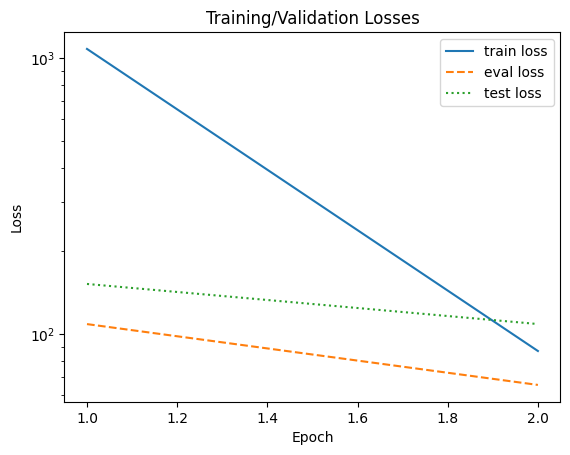

In [148]:
trainer.plot_losses()

## Evaluation on the test set

In [193]:
df[df['unit'].isin([11, 14, 15])]
# df['unit'].value_counts()

,T24,T30,T48,T50,P15,P2,P21,P24,Ps30,P40,...,Wf,alt,Mach,TRA,T2,RUL,Fc,unit,hs,cycle
526345,587.55176,1392.6290,1745.5461,1194.7870,15.387780,11.571453,15.622112,19.336557,306.66547,311.75990,...,3.497345,9915.171,0.462184,68.345610,498.27515,58,3,11,1,1
526346,596.92370,1436.2759,1822.2648,1223.3353,15.802519,11.446113,16.043165,20.250526,337.63956,343.00833,...,3.965045,9998.169,0.450689,79.479470,496.89423,58,3,11,1,1
526347,592.77140,1417.4500,1789.5046,1210.7148,15.581410,11.462285,15.818690,19.811490,323.73782,328.97504,...,3.758284,10080.394,0.457786,74.894844,497.24078,58,3,11,1,1
526348,594.96230,1428.3202,1808.8282,1217.5773,15.651453,11.400566,15.889800,20.002430,331.05667,336.35390,...,3.870138,10167.098,0.454808,77.822900,496.64078,58,3,11,1,1
526349,593.06350,1420.5859,1795.5892,1212.1064,15.525115,11.374484,15.761538,19.781378,324.95578,330.19043,...,3.780490,10259.692,0.456851,76.098630,496.48553,58,3,11,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
592690,541.80870,1197.2739,1419.9021,1067.5966,12.897849,11.182841,13.094263,14.806892,174.95969,178.62355,...,1.625908,10125.515,0.420033,26.282180,493.83298,0,3,11,0,59
592691,540.61786,1193.0080,1413.1051,1065.4204,12.840362,11.167685,13.035900,14.700809,172.18580,175.81840,...,1.585921,10065.838,0.413712,25.333150,493.53270,0,3,11,0,59
592692,543.61743,1206.3185,1435.6514,1074.5166,13.009152,11.186693,13.207261,15.009285,181.39047,185.12020,...,1.717553,10009.966,0.412550,28.223360,493.66418,0,3,11,0,59
592693,536.32490,1176.6847,1386.7429,1056.3007,12.620690,11.117276,12.812883,14.299500,161.36028,164.87064,...,1.431431,9947.193,0.397942,21.756405,492.68323,0,3,11,0,59


In [194]:
df_test, df_out = trainer.eval_rul_prediction(LOADERS[-1])

Evaluating test RUL...
Model CNN saved in models/best_model_1031184853.pt loaded to cpu


100%|██████████| 451/451 [00:25<00:00, 17.46it/s]


<Axes: >

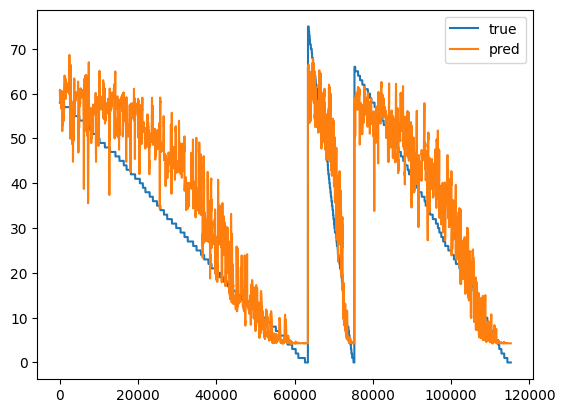

In [195]:
df_test.plot(y=['true', 'pred'])

In [196]:
zero_indices = df_test.index[df_test['true'] == 0].tolist()

# Find the reset indices (where it goes from 0 to greater than 0)
reset_indices = []
for idx in zero_indices:
    # Check the next value after 0
    if idx + 1 < len(df_test) and df_test['true'].iloc[idx + 1] > 0:
        reset_indices.append(idx + 1)

reset_indices

[63400, 75277]

In [218]:
df_test_cycle11 = df_test.loc[0:63399]
df_test_cycle14 = df_test.iloc[63400:75276]
df_test_cycle15 = df_test.loc[75277:]

(39997, 3)

In [217]:
print('Result on Cycle 11: ', Trainer.evaluate_model_performance(df_test_cycle11['pred'], df_test_cycle11['true']))
print('Result on Cycle 14: ', Trainer.evaluate_model_performance(df_test_cycle14['pred'], df_test_cycle14['true']))
print('Result on Cycle 15: ', Trainer.evaluate_model_performance(df_test_cycle15['pred'], df_test_cycle15['true']))

Result on Cycle 11:  (np.float64(0.9471831979540826), np.float32(9.394938))
Result on Cycle 14:  (np.float64(0.1721517524950706), np.float32(9.527599))
Result on Cycle 15:  (np.float64(0.33045947642532897), np.float32(6.7121706))


This is showing that our model performs best on test unit 15, which is flight class 2. This is weird!

## Aggregate results of multiple runs

In [198]:
def run_single(seed, params=DEFAULT_PARAMS):
  seed_everything(seed)

  model = CNN(
    in_channels=params['in_channels'],
    out_channels=params['out_channels'],
    n_ch=params['n_ch'],
    n_k=params['n_k'],
    n_hidden=params['n_hidden'],
    n_layers=params['n_layers'],
    dropout=params['dropout'],
  )

  optimizer = torch.optim.Adam(
    model.parameters(),
    lr=params['base_lr'],
    weight_decay=params['weight_decay'],
  )

  criterion = nn.MSELoss()
  trainer = Trainer(
    model,
    optimizer,
    criterion=criterion,
    n_epochs=params['max_epochs'],
    seed=seed,
  )

  trainer.fit(LOADERS)
  df_eval, df_eval_out = trainer.eval_rul_prediction(LOADERS[1])
  df_test, df_test_out = trainer.eval_rul_prediction(LOADERS[2])
  return df_eval, df_eval_out, df_test, df_test_out

N_RUNS = 5
df_all = pd.DataFrame()
for seed in range(SEED, SEED+N_RUNS):
  df_eval, df_eval_out, df_test, df_test_out = run_single(seed)
  df_all = df_all.append(df_test_out)

Training model for 2 epochs...


KeyboardInterrupt: 

## Bonus: Hyperparameter tuning

**Model parameters:** These are the parameters that are estimated by the model from the given data. For example the weights of a deep neural network. 

**Model hyperparameters:** These are the parameters that cannot be estimated by the model from the given data. These parameters are used to estimate the model parameters. For example, the learning rate in deep neural networks.

*Hyperparameter tuning* (or hyperparameter optimization) is the process of determining the right combination of hyperparameters that maximizes the model performance. It works by running multiple trials in a single training process. Each trial is a complete execution of your training application with values for your chosen hyperparameters, set within the limits you specify. This process once finished will give you the set of hyperparameter values that are best suited for the model to give optimal results.

There are many python libraries for hyperparameter tuning:
1. RayTune
2. Optuna
3. Hyperopt
4. sklearn
etc.

Here we will build a simple tuner using Optuna

In [ ]:
!pip install -U optuna

There are several ways of hyperparameter tuning (all the above mentioned libraries apply several or all of those):

GridSearch : We create a discrete search space of hyperparameters to be tuned. This descrete search space grid is exhaustively searched for the best combination.

RandomSearch : We define distributions for each hyperparameter. Here the key difference is not all values are tested and values are selected at random. Since randomsearch does not test all hyperparameter values it does not necessarily return the best performing parameters, but it returns a good performing model in significantly shorter time

In [ ]:
import optuna

This is an example of random search, Optuna Tune uses Bayesian optimization by default, however for this time we use the random search algorithm.


In [ ]:
def evaluate_model(params):
    n_runs = 3 # number of runs to average over, you can decrease this number to speed up the optimization
    df_all_val = pd.DataFrame()
    for i in n_runs:
        seed = SEED + i
        df_eval, df_eval_out, df_test, df_test_out = run_single(seed, params)
        df_all_val = df_all_val.append(df_eval_out) # append the validation results
    # average over n_runs of the validation results, we use the mean of the rmse as the objective to minimize
    # we use the validation results for hyperparameter tuning
    rmse = df_all_val['rmse'].mean()
    return rmse

In [ ]:
def objective(trial):
    # We can add all the parameters that use for defining the model and trainer or even the dataset builder.

    # we define the parameter space, you can add more parameters to tune or reduce, you can also start with the best hyperparameters defined in the paper and finetune
    params = DEFAULT_PARAMS.copy()
    params['base_lr'] = trial.suggest_categorical('base_lr', [0.001, 0.01, 0.1])
    params['n_layer'] = trial.suggest_categorical('kernel_size ', [3, 4, 5])
    params['kernel_size'] = trial.suggest_categorical('kernel_size ', [3, 5, 7])
    ...
    
    out = evaluate_model(params)
    # We need to minimize the predicted rmse.
    rmse = out['rmse']
    return rmse 


In [ ]:
# define a study name, otherwise a random name will be generated
study_name = 'hypertune_1'

In [ ]:
n_trials = 2 # number of set of hyperparameters to train
# based on the output of the objective, we either maximize or minimize. If we returned accuracy, we would be maximize.    
study = optuna.create_study(f'sqlite:///{folder}/study.db',
                            study_name=study_name,
                            direction="minimize",
                            load_if_exists=True,)
study.optimize(objective, n_trials=n_trials)

In [ ]:
# Load the study for resuming, comment out when reloading
# study = optuna.load_study(study_name=study_name, storage=f'sqlite:///{folder}/study.db')

### Visualizing impact of hyperparameters

In [ ]:
# You can visualize the importance of hyperparameters
fig = optuna.visualization.plot_param_importances(study)
fig.show()

In [ ]:
# Contour plot between two hyperparameters
fig = optuna.visualization.plot_contour(study, params=['lr', 'nl'])
fig.show()

In [ ]:
# you can get a dataframe of the hyperparamter results with:
hyper_df = study.trials_dataframe()
hyper_df

### Get the best model parameter

In [ ]:
# Get the est model parameter
best_trial = study.best_trial
for key, value in best_trial.params.items():
    print(f"{key}: {value:.5f}")

# Assignment 3: Prognostics for Turbofine Engines with 1D Convolutional Neural Networks 🩺

## I. Task Description:

### Background:
Conventional CNNs, primarily developed for image analysis, have shown immense capability in autonomously extracting features from 2D data. This autonomy, achieved through striding or windowing, enables the application of CNNs across various image dimensions without requiring domain expertise. 

Similarly, 1D CNNs have demonstrated effectiveness in time series data analysis by employing a windowing technique to scan through sequential data, extracting valuable features autonomously. This characteristic of 1D CNNs makes them a powerful tool for prognostics, a field concerned with predicting the Remaining Useful Life (RUL) of systems based on historical and real-time operational data.

### Problem Formulation 🚀:
In this task, the objective is to delve into the domain of prognostics to address a real-world problem. Utilizing the architecture described in the paper: "Fusing Physics-based and Deep Learning Models for Prognostics" ([link](https://arxiv.org/abs/2003.00732)), you have to develop a 1D CNN model to predict the Remaining Useful Life (RUL) of certain units. The provided dataset comprises time series data from different units, and your goal is to accurately estimate the RUL for specified test units.

Training units (engines) **2, 5, 10, 16, 18, 20** 

Test units (engines) **11, 14, 15** 

### Exploratory Data Analysis:
1. Explore and understand the provided dataset, identifying the key features that could be indicative of a unit's health and consequently its RUL **(10 points max)**.


### Implementation:
1. Implement the 1D CNN model as per the referenced paper **(20 points max)**. Be careful with the tensor dimensions that you pass to 1DCNN. It should have (n samples, n channels, n timesteps) dimensions.
2. Investigate the effect of Dropout and Batch Normalization layers on the model's performance as regularization techniques to mitigate overfitting **(10 points max)**.

### Interpretation:
1. How do the predictions of RUL evolve over time, within a cycle (i.e a complete flight cycle consisting of taking off, crusing and landing) and between cycles, for a given unit? Visualize and discuss **(30 points max)**.
2. How well does your model generalizes to the test units? Identify possible reasons why the model may perform better on some units and worse on others **(20 points max)**. 

### Evaluation:
The performance of your implemented model should be rigorously evaluated across 5 independent runs with different random seeds to ensure the robustness of the results. 
For each run, utilize the following two common metrics applied in C-MAPSS prognostics analysis:

The performance of your implemented model should be evaluated using two common metrics applied in C-MAPSS prognostics analysis:
1. **Root Mean Square Error (RMSE)**:

$\text{RMSE} = \sqrt{\frac{1}{m^*} \sum_{j=1}^{m^*} (\Delta(j))^2}$

where $m^*$ denotes the total number of test data samples, and $\Delta(j)$ is the difference between the estimated and the real Remaining Useful Life (RUL) of the $j$-th sample, i.e., $y(j) - \hat{y}(j)$.

2. **NASA's Scoring Function (s)**:
$s = \sum_{j=1}^{m^*} \exp\left(\alpha \cdot |\Delta(j)|\right) $
where $\alpha = \frac{1}{13}$ if RUL is underestimated, and $\alpha = \frac{1}{10}$ otherwise. The scoring function $s$ is not symmetric and penalizes over-estimation more than under-estimation.


Aggregate the results from all **5 runs** to provide a mean and standard deviation for both the RMSE and NASA's Scoring Function. This aggregated evaluation will provide a more robust understanding of the model's performance on the selected prognostics task, comparing it to purely data-driven deep learning models as outlined in the referenced paper.

We provide in total **(10 points max)** for proper evaluation of the model. 

### Bonus:
1. Apply hyperparameter tuning with grid search to improve the model performance. You can start with the best hyperparameters from the paper **(10 points max)**. 
2. Explore alternative architectures or approaches to enhance the prognostic performance further **(10 points max)**.

N.B. The maximum of points can not exceed 100 points together with the bonus task.

## II. Report Submission:

Upon completion of the implementation and evaluation tasks, you are required to submit a comprehensive report summarizing your work and findings. Your report should span 5-8 pages and should be structured as follows:

#### Introduction:
- A brief introduction/literature review of 1D Convolutional Neural Networks (1DCNN) and their application in time series data analysis, particularly in prognostics.

#### Model Description:
- A detailed description of the 1DCNN model you implemented, including the architecture, layers, and any regularization techniques used.
- Mention of the hyperparameters that were tuned, and any additional modifications made to the original model architecture from the paper.

#### Methodology:
- Description of the data preparation process, training, and evaluation methodologies.
- Mention the training and testing units used as specified in the task.

#### Results and Discussion:
- Summarization of the evaluation results across 5 runs, providing the mean and standard deviation for both RMSE and NASA's Scoring Function.
- Evaluation of the performance per unit, and comparison of your model's performance with the results reported in the referenced paper.
- Discussion on the impact of Dropout and Batch Normalization (if applied), and any other observations regarding the model's performance.
- Any challenges faced during the implementation and how they were addressed.

#### Conclusion:
- Summary of key findings, lessons learned, and suggestions for future work to possibly improve the model's performance.

#### References:
- Proper citation of the paper, any other related works, and resources utilized in completing the assignment.

Ensure your report is well-organized, clear, and concise. Visual aids like graphs, tables, and diagrams should be used to enhance the explanation of your work, and comparisons made. The discussion should provide insightful analysis on the model's performance and a critical comparison with the paper's results. The report should be submitted in PDF format by **6.11.2024 Midnight 23:59**.
